In [1]:
import os
import pandas as pd
import numpy as np

# GPU UMAP
# import cudf
# import cuml

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import sys ; sys.path.insert(0, '/home/jseia/Desktop/thesis/code/stroke-seg')
from dataset.dataset import StrokeDataset
import sys ; sys.path.remove('/home/jseia/Desktop/thesis/code/stroke-seg')

import os
from pathlib import Path

datapath = Path('/home/jseia/Desktop/thesis/data/')
base_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/nnunetv2')
os.environ['nnUNet_raw'] = str(base_path/'nnUNet_raw')
os.environ['nnUNet_preprocessed'] = str(base_path/'preprocessed')
os.environ['nnUNet_results'] = str(base_path/'nnUNet_trained_models')

datapath = Path('/home/jseia/Desktop/thesis/data/')
csv_path = Path('/home/jseia/Desktop/thesis/code/stroke-seg/data/dataset.csv')

dataset = StrokeDataset(
    datapath=datapath,
    datasets=['apis', 'aisd', 'tum', 'tbi'], 
    data_csv_path=csv_path,
    cases_to_exclude=[
        '6uAB525',
        '2Fbg984',
        '5LCf528',
        '1yKF684',
        '5JwP325',
        '3qGC237',
        '4xcq375'
    ],
    pathology=['ais', 'normal'],
    modalities=['ncct', 'ncct-tilt'],
    partitions=['validation'],
    standard=['gold', 'silver', '-'],
    only_filenames=True,
    filter_discard=True
)
len(dataset)

251

In [2]:
paths = [Path(f'/home/jseia/Desktop/thesis/code/nnUNet_ais/nnunetv2/preprocessed/Dataset026_AIS/nnUNetPlansSSL_3d_fullres/{i}.npy') for i in dataset.df.subject.tolist()]

In [3]:
for p in paths:
    if not p.exists():
        print(p.name.rstrip('.npy'))


In [10]:
import yaml
import torch
import torch.nn as nn
# import cuml
from sklearn import decomposition

import numpy as np
import pandas as pd

from pathlib import Path
from typing import Union
from tqdm import tqdm
from typing import Dict

import DeSD.utils_desd as utils
from DeSD.models.res3d import DINOHead, res3d
from nnunetv2.paths import nnUNet_preprocessed
from torch.utils.data import Dataset

class EmpeddingProjector():
    def __init__(
        self, cfg_file_path: Path, chckpt_file_path: Path, device: str = 'cuda', batch_size: int = 2
    ):
        super(EmpeddingProjector, self).__init__()

        with open(cfg_file_path, 'r') as yfile:
            self.cfg = yaml.safe_load(yfile)['training']

        self.teacher = res3d(self.cfg, teacher=True)
        batch_shape = [self.cfg['batch_size'], 1] + self.cfg['global_crop_size']
        self.projector = utils.DynamicMultiCropWrapper(self.teacher,
                                                        DINOHead,
                                                        self.cfg['out_dim'],
                                                        self.cfg['use_bn_in_head'],
                                                        batch_shape,
                                                        True)
        self.projector.cuda()
        self.projector.load_state_dict(torch.load(chckpt_file_path)['teacher'], strict=True)
        self.projector = self.projector.backbone
        self.batch_size = batch_size

    def __call__(self, dataset: Union[Dataset, str]):
        nnu_dataset_name = self.cfg['dataset']
        nnu_planner = self.cfg['exp_planner']
        nnu_configuration = self.cfg['configuration']
        preprocessed_dataset_path = \
            Path(nnUNet_preprocessed) / nnu_dataset_name / f'{nnu_planner}_{nnu_configuration}'
        if isinstance(dataset, str):
            files = [i for i in preprocessed_dataset_path.iterdir() if i.name.endswith('.npy')]
            subjects = [i.name.rstrip('.npy') for i in files]
            dataset_names = ais = ['-'] *  len(files)
        elif isinstance(dataset, Dataset):
            dataset_names, files, ais, subjects = [], [], [], []
            for idx in tqdm(range(len(dataset))):
                sample = dataset[idx]
                subjects.append(sample['subject'])
                dataset_names.append(sample['dataset_name'])
                ais.append(sample['ais'])
                files.append(preprocessed_dataset_path / f'{sample["subject"]}.npy')

        results = []
        for idx, npy_path in enumerate(files):
            array = np.load(npy_path)
            array = torch.tensor(array, device='cuda')
            with torch.no_grad():
                result = self.projector(array)
            results.append(
                [subjects[idx], ais[idx], dataset_names[idx]] + 
                result.T.detach().cpu().numpy().flatten().tolist()
            )
        projection_size = len(results[0]) - 3
        columns = ['subject', 'ais', 'dataset_name'] + [f'feat{i}' for i in range(projection_size)]
        results = pd.DataFrame(results, columns=columns)
        return results

class DimReductor():
    def __init__(
        self, method: str = 'pca', verbose: bool = False, device: str = 'cuda',
        seed: int = 420, method_kwargs: Dict = {}
    ):
        super(DimReductor, self).__init__()
        self.method = method.lower()

        if (self.method in ['pca', 'incrementalpca']) and ('whiten' not in method_kwargs.keys()):
            method_kwargs['whiten'] = True
        if device == 'cuda':
            raise Exception(f'Cuda not supported')
            # if self.method == 'pca':
            #     self.model = cuml.PCA(verbose=verbose, random_state=seed, **method_kwargs)
            # elif self.method == 'ipca':
            #     self.model = cuml.IncrementalPCA(verbose=verbose, **method_kwargs)
            # elif self.method == 'umap':
            #     self.model = cuml.UMAP(verbose=verbose, random_state=seed, **method_kwargs)
            # elif self.method == 'tsne':
            #     self.model = cuml.TNSE(verbose=verbose, random_state=seed, **method_kwargs)
            # else:
            #     raise Exception(f'Method {self.method} not supported')
        else:
            self.model = decomposition.IncrementalPCA(**method_kwargs)
        self.rng = np.random.default_rng(seed=seed)

    def __call__(self, projections: Union[pd.DataFrame, np.ndarray], n_to_fit: int = None):
        meta = None
        if isinstance(projections, pd.DataFrame):
            feat_columns = [col for col in projections.columns if 'feat' in col]
            extra_cols = [col for col in projections.columns if 'feat' not in col]
            meta = projections[extra_cols]
            projections = projections[feat_columns].values

        if n_to_fit is not None:
            idxs = self.rng.random.randint(projections.shape[0], size=n_to_fit)
            sub_projections = projections[idxs, :]
            self.model.fit(sub_projections)
            projections = self.model.transform(projections)
        else:
            projections = self.model.fit_transform(projections)

        projections = pd.DataFrame(projections,
                                   columns=[f'{self.method}{i}' for i in range(projections.shape[1])])
        if meta is not None:
            projections = pd.concat([meta, projections], axis=1)
        return projections


Get projections from the raw images

In [5]:
# from tqdm import tqdm
# from pathlib import Path
# from nnunetv2.training.dataloading.utils import unpack_dataset
# # nndataset_name = 'Dataset026_AIS'
# preprocessed_dataset_path = \
#     Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/nnunetv2/preprocessed/Dataset023_AIS/nnUNetPlansSSL_3d_fullres/')
# rows = []
# max_shape = np.array([  1, 163, 197, 163])
# counts = {'apis': 0, 'aisd': 0, 'tum': 0, 'tbi': 0}
# shapes = []
# arrays = []
# avoid_list = []
# for idx in tqdm(range(len(dataset))):
#     sample = dataset[idx]
#     d_name = sample['dataset_name']
#     if d_name in avoid_list:
#         continue
#     rows.append([d_name, sample['subject'], sample['ais']])
#     npy_file = Path(preprocessed_dataset_path / f'{sample["subject"]}.npy')
#     npz_file = Path(preprocessed_dataset_path / f'{sample["subject"]}.npz')
#     if (not npy_file.exists()) and npz_file.exists():
#         unpack_dataset(preprocessed_dataset_path)
#     array = np.load(npy_file)
#     # shapes.append(array.shape)   # np.max(np.asarray(shapes), axis=0)
#     diff = max_shape - array.shape
#     left = diff//2
#     right = diff - left
#     array = np.pad(array, [(left[i], right[i]) for i in range(len(left))], constant_values=0)
#     arrays.append(array.flatten())
#     counts[d_name] += 1
#     if counts[d_name] == 20:
#         avoid_list.append(d_name)
# arrays = np.asarray(arrays)
# flat_size = arrays.shape[1]
# meta = pd.DataFrame(rows, columns=['dataset_names', 'ais', 'subjects'])
# # arrays = pd.DataFrame(arrays, columns=[str(i) for i in range(flat_size)])
# # arrays = pd.concat([meta, arrays], axis=1, ignore_index=True)

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


NameError: name 'nn' is not defined

In [15]:
projector_wo_tbi = EmpeddingProjector(
    Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/config_not_tbi_1d.yml'),
    Path('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/DeSD/non_tbi/non_tbi_1d/checkpoint.pth'),
    'cuda'
)
projections_wo_tbi = projector_wo_tbi(dataset=dataset)
del projector_wo_tbi

projector_wo_tbi_50 = EmpeddingProjector(
    Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/config_not_tbi_1d.yml'),
    Path('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/DeSD/non_tbi/non_tbi_1d/checkpoint0050.pth'),
    'cuda'
)
projections_wo_tbi_50 = projector_wo_tbi_50(dataset=dataset)

del projector_wo_tbi_50
projector_wo_tbi_00 = EmpeddingProjector(
    Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/config_not_tbi_1d.yml'),
    Path('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/DeSD/non_tbi/non_tbi_1d/checkpoint0000.pth'),
    'cuda'
)
projections_wo_tbi_00 = projector_wo_tbi_00(dataset=dataset)
del projector_wo_tbi_00

projector = DimReductor(device='cpu', method_kwargs={'n_components':2})
projections_wo_tbi_pca_100 = projector(projections_wo_tbi)
projections_wo_tbi_pca_50 = projector(projections_wo_tbi_50)
projections_wo_tbi_pca_00 = projector(projections_wo_tbi_00)

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 251/251 [00:00<00:00, 6281.11it/s]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 251/251 [00:00<00:00, 6280.85it/s]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 251/251 [00:00<00:00, 6171.85it/s]


In [17]:
projector_w_tbi = EmpeddingProjector(
    Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/config_all_datasets_1.yml'),
    Path('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/DeSD/all_datasets/all_datasets_1/checkpoint.pth'),
    'cuda'
)
projections_w_tbi = projector_w_tbi(dataset=dataset)
del projector_w_tbi

projector_w_tbi_50 = EmpeddingProjector(
    Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/config_all_datasets_1.yml'),
    Path('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/DeSD/all_datasets/all_datasets_1/checkpoint0050.pth'),
    'cuda'
)
projections_w_tbi_50 = projector_w_tbi_50(dataset=dataset)
del projector_w_tbi_50

projector_w_tbi_00 = EmpeddingProjector(
    Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/config_all_datasets_1.yml'),
    Path('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/DeSD/all_datasets/all_datasets_1/checkpoint0000.pth'),
    'cuda'
)
projections_w_tbi_00 = projector_w_tbi_00(dataset=dataset)
del projector_w_tbi_00

projector = DimReductor(device='cpu', method_kwargs={'n_components':2})
projections_w_tbi_pca_100 = projector(projections_w_tbi)
projections_w_tbi_pca_50 = projector(projections_w_tbi_50)
projections_w_tbi_pca_00 = projector(projections_w_tbi_00)

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 251/251 [00:00<00:00, 6347.88it/s]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 251/251 [00:00<00:00, 6303.18it/s]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 251/251 [00:00<00:00, 6309.91it/s]


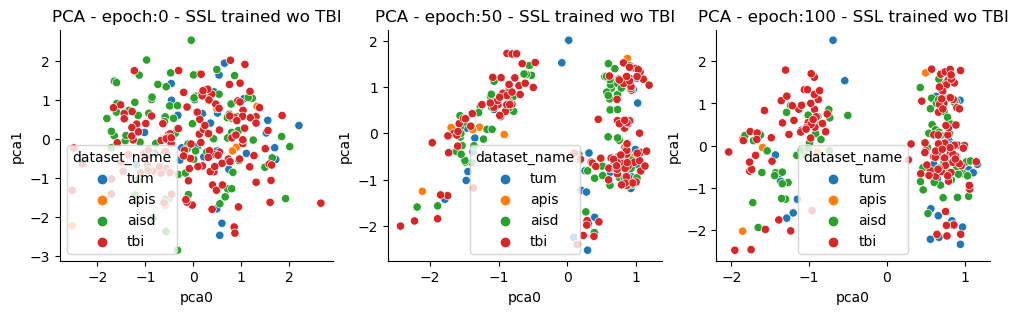

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fg, ax = plt.subplots(1, 3, figsize=(12,3))
sns.scatterplot(projections_wo_tbi_pca_00, x='pca0', y='pca1', hue='dataset_name', ax=ax[0])
ax[0].set_title('PCA - epoch:0 - SSL trained wo TBI')
sns.despine()
sns.scatterplot(projections_wo_tbi_pca_50, x='pca0', y='pca1', hue='dataset_name', ax=ax[1])
ax[1].set_title('PCA - epoch:50 - SSL trained wo TBI')
sns.despine()
sns.scatterplot(projections_wo_tbi_pca_100, x='pca0', y='pca1', hue='dataset_name', ax=ax[2])
ax[2].set_title('PCA - epoch:100 - SSL trained wo TBI')
sns.despine()
plt.show()

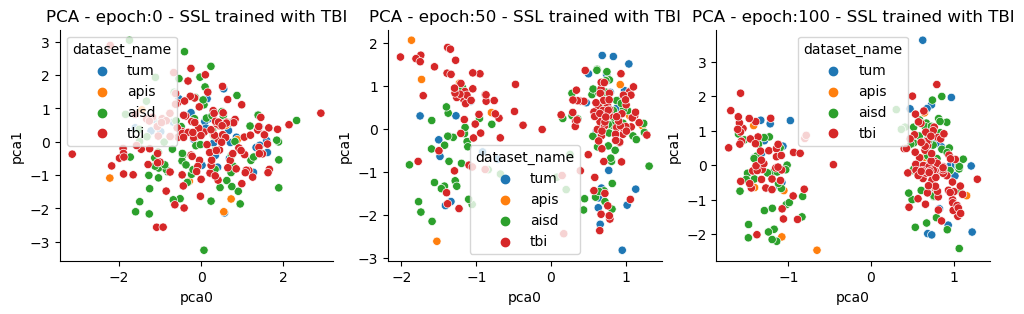

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fg, ax = plt.subplots(1, 3, figsize=(12,3))
sns.scatterplot(projections_w_tbi_pca_00, x='pca0', y='pca1', hue='dataset_name', ax=ax[0])
ax[0].set_title('PCA - epoch:0 - SSL trained with TBI')
sns.despine()
sns.scatterplot(projections_w_tbi_pca_50, x='pca0', y='pca1', hue='dataset_name', ax=ax[1])
ax[1].set_title('PCA - epoch:50 - SSL trained with TBI')
sns.despine()
sns.scatterplot(projections_w_tbi_pca_100, x='pca0', y='pca1', hue='dataset_name', ax=ax[2])
ax[2].set_title('PCA - epoch:100 - SSL trained with TBI')
sns.despine()
plt.show()

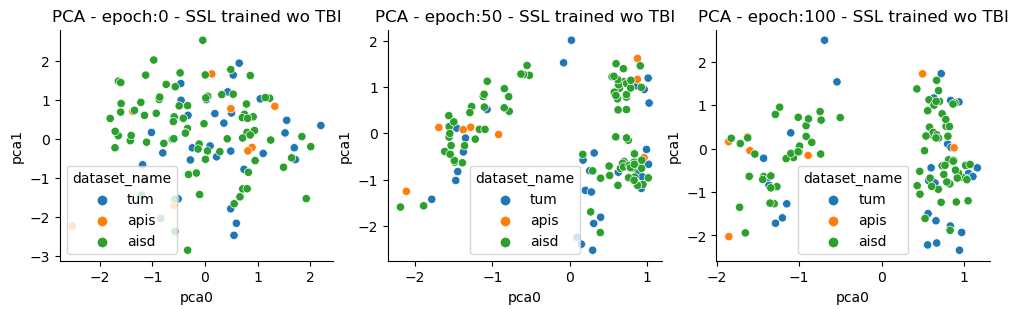

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fg, ax = plt.subplots(1, 3, figsize=(12,3))
sns.scatterplot(projections_wo_tbi_pca_00.loc[projections_wo_tbi_pca_00.dataset_name!='tbi'], x='pca0', y='pca1', hue='dataset_name', ax=ax[0])
ax[0].set_title('PCA - epoch:0 - SSL trained wo TBI')
sns.despine()
sns.scatterplot(projections_wo_tbi_pca_50.loc[projections_wo_tbi_pca_00.dataset_name!='tbi'], x='pca0', y='pca1', hue='dataset_name', ax=ax[1])
ax[1].set_title('PCA - epoch:50 - SSL trained wo TBI')
sns.despine()
sns.scatterplot(projections_wo_tbi_pca_100.loc[projections_wo_tbi_pca_00.dataset_name!='tbi'], x='pca0', y='pca1', hue='dataset_name', ax=ax[2])
ax[2].set_title('PCA - epoch:100 - SSL trained wo TBI')
sns.despine()
plt.show()

In [23]:
projections_wo_tbi_pca_100.loc[(projections_wo_tbi_pca_00.dataset_name!='tbi')&(projections_wo_tbi_pca_100.pca0<0), ['subject', 'pca0']]

,subject,pca0
3,strokeperf0014,-0.540736
12,strokeperf0056,-1.287186
14,strokeperf0062,-1.150460
17,strokeperf0071,-1.203683
19,strokeperf0076,-0.691633
20,strokeperf0103,-1.366167
23,strokeperf0120,-1.383074
26,strokeperf0146,-1.431842
28,strokeperf0159,-1.101899
32,train056,-1.597969


In [27]:
projections_wo_tbi_pca_100.loc[(projections_wo_tbi_pca_00.dataset_name=='apis')&(projections_wo_tbi_pca_100.pca0>0.5), ['subject', 'pca0']]

,subject,pca0
30,train012,0.647025
37,train042,0.881578


In [ ]:
# model = DimReductor(device='cpu', method_kwargs={'n_components':2})
# proj = model(arrays)
# pca_p = cumal.IncrementalPCA(n_components=2, whiten=True, verbose=False) 
# pca_embedding = pca_p.fit_transform(arrays)
# pca_embedding = pca_p.transform(arrays)
# umap_embedding = cuml.TSNE(n_components=2, verbose=False).fit_transform(arrays)
# pca_embedding = pd.DataFrame(pca_embedding, columns=[f'feat{i}' for i in range(pca_embedding.shape[1])])
# pca_embedding = pd.concat([meta, pca_embedding], axis=1)
# umap_embedding = pd.DataFrame(umap_embedding, columns=[f'feat{i}' for i in range(umap_embedding.shape[1])])
# umap_embedding = pd.concat([meta, umap_embedding], axis=1)

,pca0,pca1
0,0.559021,-0.880062
1,0.349600,2.027738
2,0.582947,3.266833
3,0.632596,-1.459574
4,1.454723,2.255479
...,...,...
63,-1.010164,0.037568
64,-1.509992,0.047767
65,-1.458463,0.083211
66,-1.564879,-0.053637


In [ ]:
# pca_embedding.to_csv('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/projections/pca_full_img_mni.csv')

In [1]:
import pandas as pd
pca_embedding_mni = pd.read_csv('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/projections/pca_full_img_mni.csv', index_col=0)
pca_embedding = pd.read_csv('/home/jseia/Desktop/thesis/code/stroke-seg/experiments/projections/pca_full_img.csv', index_col=0)

In [12]:
pca_embedding.columns = ['dataset_names', 'subjects', 'ais', 'feat0', 'feat1']
pca_embedding_mni.columns = ['dataset_names', 'subjects', 'ais', 'feat0', 'feat1']

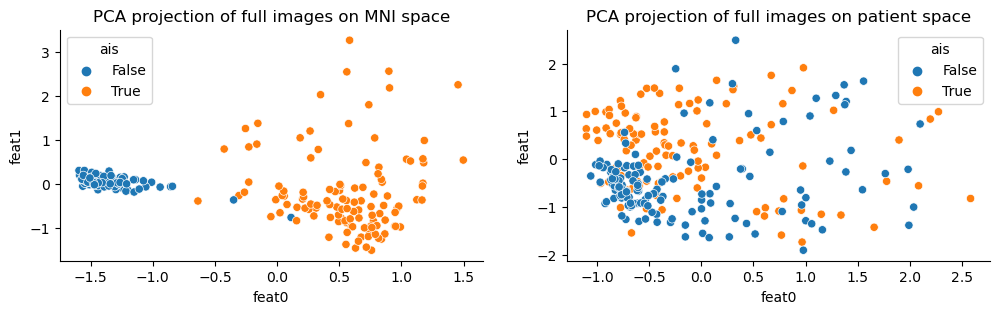

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
fg, ax = plt.subplots(1,2, figsize=(12,3))
sns.scatterplot(pca_embedding_mni, x='feat0', y='feat1', hue='ais', ax=ax[0])
ax[0].set_title('PCA projection of full images on MNI space')
sns.despine()
sns.scatterplot(pca_embedding, x='feat0', y='feat1', hue='ais', ax=ax[1])
ax[1].set_title('PCA projection of full images on patient space')
sns.despine()
plt.show()

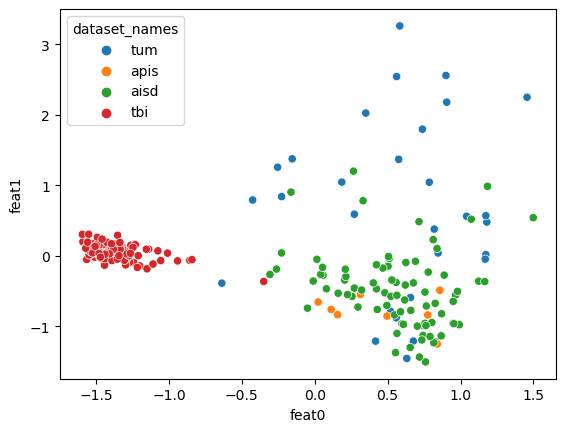

In [29]:
import seaborn as sns
plt.figure()
sns.scatterplot(pca_embedding, x='feat0', y='feat1', hue='dataset_names')
# sns.scatterplot(umap_embedding, x='feat0', y='feat1', hue='dataset_names')
plt.show()